# Switzer method demo
This methodology has not completed WRI's review process and should not be used for any purpose.

Direct questions to Ted Wong (ted.wong@wri.org).

## Problem: How to estimate future probability distributions of climate-hazard indicators
* Data source: climate simulations
    * These are global rasters of CMIP6 simulations. Outputs include daily maxtemp, mintemp, precip, and humidity for every day in years 1950-2100.
    * Downscale product is [NEX-GDDP-CMIP6](https://www.nccs.nasa.gov/services/data-collections/land-based-products/nex-gddp-cmip6). Resolution is 0.25 degrees, or approx. 25 km.
* Additional data: satellite observations
    * This is the [ERA5 reanalysis product](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5), which provides similar variables and resolution for 1940-present.
    * This dataset is not used in the proposed methodology below, but it is available if useful.
    
* Using the simulated variables, for any year we can calculate numerous climate-hazard indicators for any location. Example indicators:
     * Number of days in a year with maxtemp > 35C
     * Duration of longest uninterrupted dryspell in a year
     * Number of degree-days between final frost and first frost in a year
* For a given location and future year, we would like to estimate either...
    * Probability distributions of indicator magnitudes
    * or the probability that the indicator magnitude exceeds a given threshold
* Considerations
    * Ease of calculation
        * Use cases include implementation a a web application for on-demand calculation, and precalculation of large-area rasters. We hope to use methods that lend themselves well to parallelization.
        * We would like to be able to assess the quality of our probability estimates.

## Proposed solution: Random sampling of Poisson rate parameters

* Count exceedance events over a historical interval in both a model and an observation dataset. Also count future exceedance events in one of the climate models.
* Assume counts are Poisson-distributed.
* Using Jeffries prior, the posterior distribution of Poisson rate parameters is Gamma-distributed with shape parameter equal to the event count plus one-half.
* Different models have biases. We'll use the historical observations and historical model data to calibrate each model's future event count. Define a calibration function as follows:
    * Take 10,000 draws from the Gamma distribution using the count from the historical observation dataset as shape parameter. Call these gH_draws.
    * Similar for the historical modeled data: 10,000 draws from Gamma($\alpha$ = historical model count). Call these gHM_draws.
    * Order gH_draws and gHM_draws by size.
    * For j = 1...1000, let X(j,gH) and X(j,gHM) denote the j-th largest value of gH_draws and gHM_draws. Let n(j,gHM) denote the number of gHM sample values that are smaller than X(j,gH). Then the calibrated value of X(j,gHM) is X(n(j),gHM), for j = 1..1000.
    * This defines a mapping from j --> n(j). This mapping is the calibration function.
* Apply the calibration function to gFM_draws to get calibrated gFM_draws, or cgFM_draws. This is the calibrated distribution of Poisson rate parameters.
* Uniformly draw 1000 Poisson parameters from cgFM_draws. Use these 1000 drawn Poisson parameters to generate 1000 Poisson distributions. From each, draw one future exceedance event count.
* Report the mean of the event-count distribution, and display the distribution.
* Do all this for each model and report results separately. Maybe also report the mean value. (Or evaluate models by the distance between gH and gHM, and use only the best model.)




----------------------------------------------------

# Demo implementation

### Import libraries set authentication credentials, etc.

In [2]:
import ee
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import datetime, calendar

plt.style.use("seaborn-darkgrid")

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AVHEtk4oWUw7jXhVfd-OwCLV-NoZcvqlh0ZvJI87JGpd7mfUfMOz8EhfQXQ

Successfully saved authorization token.


--------------------------
### Select CMIP6 models and define a location and future year of interest

In [126]:
LEAPLENGTH = {'UKESM1-0-LL': 360,
 'NorESM2-MM': 365,
 'NorESM2-LM': 365,
 'MRI-ESM2-0': 366,
 'MPI-ESM1-2-LR': 366,
 'MPI-ESM1-2-HR': 366,
 'MIROC6': 366,
 'MIROC-ES2L': 366,
 'KIOST-ESM': 365,
 'KACE-1-0-G': 360,
 'IPSL-CM6A-LR': 366,
 'INM-CM5-0': 365,
 'INM-CM4-8': 365,
 'HadGEM3-GC31-MM': 360,
 'HadGEM3-GC31-LL': 360,
 'GFDL-ESM4': 365,
 'GFDL-CM4_gr2': 365,
 'GFDL-CM4': 365,
 'FGOALS-g3': 365,
 'EC-Earth3-Veg-LR': 366,
 'EC-Earth3': 366,
 'CanESM5': 365,
 'CNRM-ESM2-1': 366,
 'CNRM-CM6-1': 366,
 'CMCC-ESM2': 365,
 'CMCC-CM2-SR5': 365,
 'BCC-CSM2-MR': 365,
 'ACCESS-ESM1-5': 366,
 'ACCESS-CM2': 366,
 'TaiESM1': 365,
 'ERA5': 366
}

EXCLUDED_MODELS = ['TaiESM1', 'GFDL-CM4_gr2','ERA5']    # TaiESM1 model has major known biases

MODELS = [i for i in LEAPLENGTH.keys() if not i in EXCLUDED_MODELS]

INITIAL_LATLON = (22.75, 87.82)
INITIAL_WINDOW = ('04-15', '09-10')
TEST_THRESHOLD = 120

HIST_START = 1979
HIST_END = 2015
FUTURE_START = 2050
FUTURE_END = 2070

NUM_BEST_MODELS = 6

In [185]:
mod_counts

{'UKESM1-0-LL': array([59, 44, 95, 53, 62, 56, 73, 91, 58, 67, 48, 57, 52, 41, 44, 69, 56,
        57, 59, 82, 69, 57, 60, 69, 47, 51, 72, 65, 60, 60, 41, 56, 50, 70,
        69, 60]),
 'NorESM2-MM': array([50, 55, 48, 50, 58, 55, 55, 54, 60, 48, 53, 80, 55, 49, 48, 69, 61,
        57, 55, 43, 48, 27, 35, 28, 68, 85, 59, 53, 40, 36, 42, 60, 42, 37,
        68, 68]),
 'NorESM2-LM': array([49, 59, 51, 45, 65, 72, 55, 66, 41, 53, 44, 53, 46, 43, 36, 54, 71,
        58, 62, 66, 52, 68, 61, 56, 45, 68, 48, 49, 66, 63, 55, 38, 42, 60,
        40, 67]),
 'MRI-ESM2-0': array([38, 63, 51, 68, 52, 76, 61, 43, 84, 55, 55, 80, 12, 40, 57, 70, 40,
        56, 48, 22, 34, 68, 30, 51, 44, 24, 58, 68, 70, 54, 77, 62, 52, 61,
        68, 51]),
 'MPI-ESM1-2-LR': array([34, 62, 56, 73, 63, 66, 69, 27, 31, 53, 33, 65, 62, 49, 57, 64, 29,
        53, 65, 69, 57, 62, 56, 60, 54, 45, 67, 23, 65, 55, 55, 27, 66, 72,
        50, 48]),
 'MPI-ESM1-2-HR': array([68, 54, 22, 51, 66, 43, 64, 55, 43, 60, 50, 45, 51,

--------------------------------------
### Define indicator of interest
This indicator counts the number of days within a given window in the year with maximum temperature >= 35C

In [181]:
indicators = {
    'dtg34': {
            'name': 'dtg34',
            'greaterthan': True,
            'nex_varname': 'tasmax',
            'era5_varname': 'maximum_2m_air_temperature',
            'range': [1, 365, 1],
            'nex_multiply': 1,
            'nex_add': -273.15,
            'era5_multiply': 1,
            'era5_add': -273.15,
            'function': lambda windowdata: np.sum(windowdata >= 35, axis=0),
            'prob_model': 'binomial'
    } 
}


def get_mags(lat, lon, window, start_year, end_year, model, indicator, scenario='ssp585'):

# Returns array of event counts, one for each year
    
    def d2j(datestring):
        d = datetime.date.fromisoformat(datestring)
        jday = d.timetuple().tm_yday
        if calendar.isleap(d.year) and jday > 59:
            jday -= 1
        return jday
    
    if model == 'ERA5':
        varname = indicator['era5_varname']
        is_forecast = varname == "precipitation_amount_1hour_Accumulation"
        dataset = ee.ImageCollection("ECMWF/ERA5/DAILY")
        mult = indicator['era5_multiply']
        add = indicator['era5_add']
    else:
        varname = indicator['nex_varname']
        dataset = ee.ImageCollection('NASA/GDDP-CMIP6').filter(ee.Filter.eq('model', model))
        mult = indicator['nex_multiply']
        add = indicator['nex_add']
    indicator_fxn = indicator['function']
    gee_geom = ee.Geometry.Point((lon, lat))

    allyears = []
    for year in range(start_year, end_year):
        window_start = datetime.datetime.strptime('{0}-{1}'.format(year, window[0]), '%Y-%m-%d')
        window_end_plusone = datetime.datetime.strptime('{0}-{1}'.format(year, window[1]), '%Y-%m-%d') + datetime.timedelta(days=1) 
        data_vars = dataset.select(varname).filter(ee.Filter.date(window_start.strftime('%Y-01-01'), window_end_plusone.strftime('%Y-12-31')))
        if model != 'ERA5':
            data_vars = data_vars.filter(ee.Filter.eq('scenario', [scenario, 'historical'][int(year < 2015)]))
        yeardata = pd.DataFrame(data_vars.getRegion(gee_geom, 25000, 'epsg:4326').getInfo())[4][1:]
        yeardata = np.array(yeardata[d2j(window_start.strftime('%Y-%m-%d'))+1: d2j(window_end_plusone.strftime('%Y-%m-%d'))+1])
        allyears.append(indicator_fxn((np.array(yeardata) * mult) + add))
    return np.array(allyears)

In [60]:
def get_rmsd(d1, d2):
    if d1.size != d2.size:
        raise Exception("Comparing arrays of different length")
    interval_length = d1.size // 4
    c1 = np.array([])
    c2 = np.array([])
    for i in range(4):
        c1 = np.append(c1, sum(d1[i*4:(i+1)*4]))
        c2 = np.append(c2, sum(d2[i*4:(i+1)*4]))
    return np.sqrt(((c1 - c2)**2).sum() / d1.size)

def calibration_function(hist_obs, hist_mod):
    new_indices = []
    source = np.sort(hist_obs)
    target= np.sort(hist_mod)
    source[-1] = target[-1]  # when target[i] greater than all source values, return max index
    for target_idx, target_value in enumerate(target):
        source_value = source[target_idx]
        new_indices.append(np.argmax(target >= source_value))
    return new_indices

def gamma(count, size):
    return np.random.gamma(shape = count + 0.5, size=size)

def beta(count, num, size):
    return np.random.beta(a = count + 0.5, b = num - count + 0.5, size=size)

In [78]:
rmsd_to_models = {}
print('Getting historical event counts')
obs_counts = np.array(get_mags(INITIAL_LATLON[0], INITIAL_LATLON[1], INITIAL_WINDOW, HIST_START, HIST_END, 'ERA5', indicators['dtg34'], INITIAL_THRESHOLD))

mod_counts = {}

for model in MODELS:
    mod_counts[model] = np.array(get_mags(INITIAL_LATLON[0], INITIAL_LATLON[1], INITIAL_WINDOW, HIST_START, HIST_END, model, indicators['dtg34']))
    rmsd_to_models[get_rmsd(obs_counts, mod_counts[model])] = model

print('Evaluating models')
rmsd_vals = list(rmsd_to_models.keys())
rmsd_vals.sort()
best_models = [rmsd_to_models[i] for i in rmsd_vals[:NUM_BEST_MODELS]]
print('  Best models: {0}'.format(', '.join(best_models)))

indicator = indicators['dtg34']
successes = []
print('\n\n')
for model in best_models:
    print(model)
    print('  Getting future event count')
    fmod = get_mags(INITIAL_LATLON[0], INITIAL_LATLON[1], INITIAL_WINDOW, FUTURE_START, FUTURE_END, model, indicators['dtg34'])
    print('  Calibrating posterior distribution')
    if indicator['prob_model'] == 'poisson':
        
        posteriorH_draws = gamma(obs_counts.sum(), 10000)
        posteriorHM_draws = gamma(mod_counts[model].sum(), 10000)
        posteriorFM_draws = gamma(fmod.sum(), 10000)
    else:
        
        fmod = fmod >= TEST_THRESHOLD
        hobs = obs_counts >= TEST_THRESHOLD
        hmod = mod_counts[model] >= TEST_THRESHOLD
        
        posteriorH_draws = beta(hobs.sum(), hobs.size, 10000)
        posteriorHM_draws = beta(hmod.sum(), hmod.size, 10000)
        posteriorFM_draws = beta(fmod.sum(), fmod.size, 10000)
    cposteriorFM_draws = posteriorFM_draws[calibration_function(posteriorH_draws, posteriorHM_draws)]
    print('  Sampling')
    uniform_draws = np.random.randint(low=0, high=10000, size=1000)
    if indicator['prob_model'] == 'poisson':
        cFM_draws = np.random.poisson(lam=cposteriorFM_draws[uniform_draws], size=1000)
    else:
        cFM_draws = np.random.binomial(n=fmod.size, p=cposteriorFM_draws[uniform_draws], size=1000) / fmod.size
    
    successes.append(cFM_draws)
    print('  Event frequency: {0:.2f}%\n'.format((cFM_draws.mean()) * 100 ))
    
fig, ax = plt.subplots()
ax.boxplot(successes)
ax.set_xticklabels(best_models, rotation=45, fontsize=12)
plt.show()

ERA5 1979-2014
UKESM1-0-LL 1979-2014
NorESM2-MM 1979-2014
NorESM2-LM 1979-2014
MRI-ESM2-0 1979-2014
MPI-ESM1-2-LR 1979-2014
MPI-ESM1-2-HR 1979-2014
MIROC6 1979-2014
MIROC-ES2L 1979-2014
KIOST-ESM 1979-2014
KACE-1-0-G 1979-2014
IPSL-CM6A-LR 1979-2014
INM-CM5-0 1979-2014
INM-CM4-8 1979-2014
HadGEM3-GC31-MM 1979-2014
HadGEM3-GC31-LL 1979-2014
GFDL-ESM4 1979-2014
GFDL-CM4 1979-2014
FGOALS-g3 1979-2014
EC-Earth3-Veg-LR 1979-2014
EC-Earth3 1979-2014
CanESM5 1979-2014
CNRM-ESM2-1 1979-2014
CNRM-CM6-1 1979-2014
CMCC-ESM2 1979-2014
CMCC-CM2-SR5 1979-2014
BCC-CSM2-MR 1979-2014
ACCESS-ESM1-5 1979-2014
ACCESS-CM2 1979-2014
Best models: FGOALS-g3, INM-CM4-8 and CanESM5


FGOALS-g3
  Getting future event count
  Calibrating posterior distribution
  Sampling event counts
INM-CM4-8
  Getting future event count
  Calibrating posterior distribution
  Sampling event counts
CanESM5
  Getting future event count
  Calibrating posterior distribution
  Sampling event counts
CNRM-ESM2-1
  Getting future event count
  Calibrating posterior distribution
  Sampling event counts
IPSL-CM6A-LR
  Getting future event count
  Calibrating posterior distribution
  Sampling event counts
MPI-ESM1-2-HR
  Getting future event count
  Calibrating posterior distribution
  Sampling event counts

EVENT PROBABILITIES
  2.62% (FGOALS-g3)
  2.61% (INM-CM4-8)
  40.42% (CanESM5)
  2.44% (CNRM-ESM2-1)
  11.65% (IPSL-CM6A-LR)
  2.24% (MPI-ESM1-2-HR)


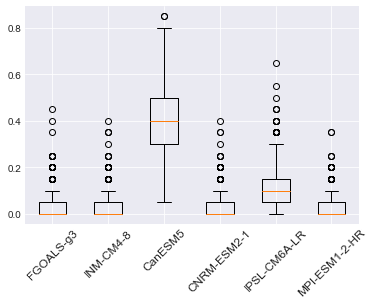

In [182]:
successes = []
freqs = {}
for model in best_models:
    print(model)
    print('  Getting future event count')
    fmod = get_mags(INITIAL_LATLON[0], INITIAL_LATLON[1], INITIAL_WINDOW, FUTURE_START, FUTURE_END, model, indicators['dtg34'])
    print('  Calibrating posterior distribution')
    if indicator['prob_model'] == 'poisson':
        
        posteriorH_draws = gamma(obs_counts.sum(), 10000)
        posteriorHM_draws = gamma(mod_counts[model].sum(), 10000)
        posteriorFM_draws = gamma(fmod.sum(), 10000)
    else:
        
        fmod = fmod >= TEST_THRESHOLD
        hobs = obs_counts >= TEST_THRESHOLD
        hmod = mod_counts[model] >= TEST_THRESHOLD
        
        posteriorH_draws = beta(hobs.sum(), hobs.size, 10000)
        posteriorHM_draws = beta(hmod.sum(), hmod.size, 10000)
        posteriorFM_draws = beta(fmod.sum(), fmod.size, 10000)
    cposteriorFM_draws = posteriorFM_draws[calibration_function(posteriorH_draws, posteriorHM_draws)]
    print('  Sampling event counts')
    uniform_draws = np.random.randint(low=0, high=10000, size=1000)
    if indicator['prob_model'] == 'poisson':
        cFM_draws = np.random.poisson(lam=cposteriorFM_draws[uniform_draws], size=1000)
    else:
        cFM_draws = np.random.binomial(n=fmod.size, p=cposteriorFM_draws[uniform_draws], size=1000) / fmod.size
        freqs[model] = cFM_draws.mean()
    successes.append(cFM_draws)
print()
print('EVENT PROBABILITIES')
for model in best_models:
    print('  {0:.2f}% ({1})'.format(freqs[model] * 100, model))
fig, ax = plt.subplots()
ax.boxplot(successes)
ax.set_xticklabels(best_models, rotation=45, fontsize=12)
plt.show()

--------------------------------------------------------
### Define the calibration function

1. Sort gH and gHM by increasing size.
2. For each jth value of gHM...
    1. Find the jth value of gH. Call it _source_value_.
    2. Find the position in the gHM's where the value is greater than or equal to _source_value_.
    3. Record that position in the jth position of an array.
    
The resulting array is an array of indices. Reordering gHM or gFM by these indices, yields a calibrated distribution cgHM or cgFM.

Apply the calibration function to the future draws to get a distribution of calibrated future Poisson parameters.

------------------------------------------------------------
### Draw future event counts from Poisson distributions

* Draw 1000 Poisson parameters from cgFM_draws
* From each drawn parameter, generate a Poisson distribution
* Draw one future event count from each Poisson distribution

------------------------------------------------------------------
### Visualize the distribution of future event counts